In [1]:
!conda env list

# conda environments:
#
base                  *  /users/avanti/anaconda3
py2diabeticretinopathy     /users/avanti/anaconda3/envs/py2diabeticretinopathy
py35                     /users/avanti/anaconda3/envs/py35



In [6]:
!pwd

/users/avanti/kaggle_diabetic_retinopathy/notebooks


In [2]:
import gzip
import numpy as np
from scipy.special import softmax

#average over the different augmentations
def load_deterministic_labels(pred_folder):
    subfolder_names = [
        pred_folder+"/xyflip-False_horizontalflip-False_verticalflip-False",
        pred_folder+"/xyflip-False_horizontalflip-False_verticalflip-True",
        pred_folder+"/xyflip-False_horizontalflip-True_verticalflip-False",
        pred_folder+"/xyflip-False_horizontalflip-True_verticalflip-True",
        pred_folder+"/xyflip-True_horizontalflip-False_verticalflip-False",
        pred_folder+"/xyflip-True_horizontalflip-False_verticalflip-True",
        pred_folder+"/xyflip-True_horizontalflip-True_verticalflip-False",
        pred_folder+"/xyflip-True_horizontalflip-True_verticalflip-True"
    ]
    softmax_logits = []
    for subfolder in subfolder_names:
        softmax_logits.append(
            np.array([[float(y) for y in x.decode("utf-8").split("\t")[1:]]
                     for x in gzip.open(subfolder+"/deterministic_preds.txt.gz", 'rb')]))
    softmax_logits = np.mean(softmax_logits, axis=0)
    return softmax_logits

kaggle_labels = np.array([int(x.decode("utf-8").split("\t")[1])
                              for x in gzip.open("valid_labels.txt.gz", 'rb')])
kaggle_softmax_logits = load_deterministic_labels("kaggle_preds")
kaggle_softmax_preds = softmax(kaggle_softmax_logits, axis=-1)
from sklearn.metrics import roc_auc_score
kaggle_binary_labels = 1.0*(kaggle_labels > 0.0)
kaggle_binary_preds = 1-kaggle_softmax_preds[:,0]
kaggle_binary_logits = (np.log(np.maximum(kaggle_binary_preds,1e-7))
                        -np.log(np.maximum(1-kaggle_binary_preds, 1e-7)))
print(roc_auc_score(y_true=kaggle_binary_labels,
                    y_score=kaggle_binary_preds))

messidor_labels = np.array([
    int(x[1].decode("utf-8").split("\t")[2]) for x in
    enumerate(gzip.open("messidor_preds/messidor_labels_withcorrections.txt.gz", 'rb'))
    if x[0] > 0])
messidor_softmax_logits = load_deterministic_labels("messidor_preds")
messidor_softmax_preds = softmax(messidor_softmax_logits, axis=-1)
from sklearn.metrics import roc_auc_score
messidor_binary_labels = 1.0*(messidor_labels > 0.0)
messidor_binary_preds = 1-messidor_softmax_preds[:,0]
messidor_binary_logits = (np.log(np.maximum(messidor_binary_preds,1e-7))
                               -np.log(np.maximum(1-messidor_binary_preds,1e-7)))

print(roc_auc_score(y_true=messidor_binary_labels,
                    y_score=messidor_binary_preds))

0.8945151902722942
0.8920633498604387


/users/avanti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Platt scaling coef: 0.46695670532656974 ; intercept: -0.7060032062094537
Kaggle before calibration


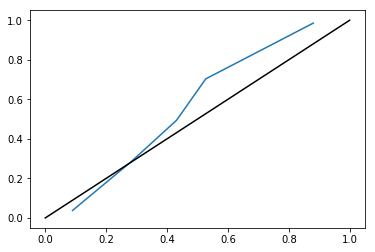

Kaggle after calibration


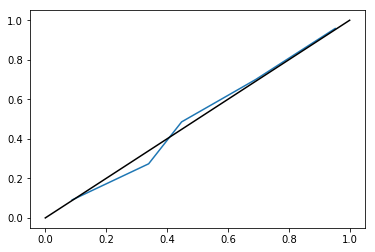

Messidor before calibration


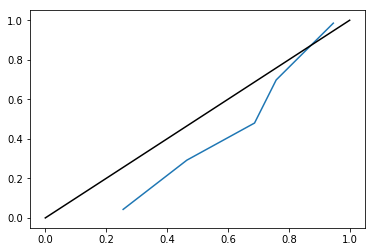

Messidor after calibration


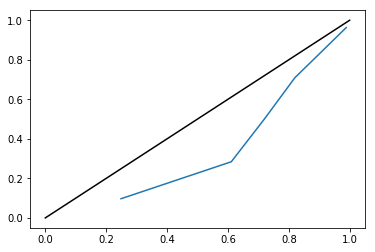

Messidor after adaptation


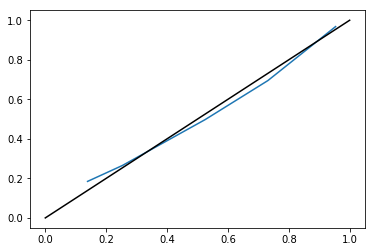

In [4]:
%matplotlib inline

#apply calibration to the kaggle set
import abstention
from abstention.calibration import PlattScaling
from abstention.label_shift import EMImbalanceAdapter
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt

def plot_calibration_curve(y_true, y_preds, **kwargs):
    prob_true, prob_pred = calibration_curve(
        y_true=y_true,
        y_prob=y_preds,
        **kwargs)
    plt.plot(prob_true, prob_pred)
    plt.plot([0,1],[0,1], color="black")
    plt.show()
    

calibrator = PlattScaling()(valid_preacts=kaggle_binary_logits,
                            valid_labels=kaggle_binary_labels)
calibrated_kaggle_preds = calibrator(kaggle_binary_logits)
calibrated_messidor_preds = calibrator(messidor_binary_logits)
adaptation_func = EMImbalanceAdapter()(
    tofit_initial_posterior_probs=calibrated_messidor_preds,
    valid_posterior_probs=calibrated_kaggle_preds)
adapted_calibrated_messidor_preds = adaptation_func(calibrated_messidor_preds)

print("Kaggle before calibration")
plot_calibration_curve(y_true=kaggle_binary_labels,
                       y_preds=kaggle_binary_preds,
                       n_bins=5)
print("Kaggle after calibration")
plot_calibration_curve(y_true=kaggle_binary_labels,
                       y_preds=calibrated_kaggle_preds)
print("Messidor before calibration")
plot_calibration_curve(y_true=messidor_binary_labels,
                       y_preds=messidor_binary_preds,
                       n_bins=5)
print("Messidor after calibration")
plot_calibration_curve(y_true=messidor_binary_labels,
                       y_preds=calibrated_messidor_preds,
                       n_bins=5)
print("Messidor after adaptation")
plot_calibration_curve(y_true=messidor_binary_labels,
                       y_preds=adapted_calibrated_messidor_preds,
                       n_bins=5)

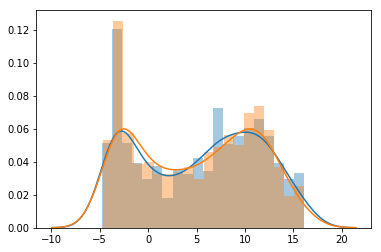

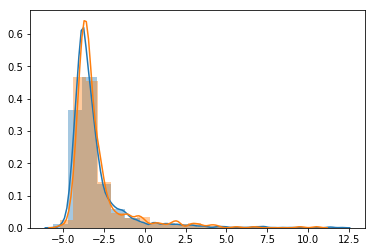

In [5]:
%matplotlib inline
#investigate difference in positives/negatives for the two datasets
from matplotlib import pyplot as plt
import seaborn as sns
sns.distplot(kaggle_binary_logits[kaggle_binary_labels==1.0], bins=20)
sns.distplot(messidor_binary_logits[messidor_binary_labels==1.0], bins=20)
plt.show()

sns.distplot(kaggle_binary_logits[kaggle_binary_labels==0.0], bins=20)
sns.distplot(messidor_binary_logits[messidor_binary_labels==0.0], bins=20)
plt.show()